## Exploratory Data Analysis

In this section, we will:

- Summarize the dataset structure
- Visualize the distribution of player ages
- Explore relationships between age and key performance metrics
- Explore how performance statistics affect a player's market value
- Explore which metrics correlate to high performace

In [11]:
from src import utils

path = "/Users/charlierobinson/Documents/Code/SheffUtd/SUFC/data/SUFC Data Scientist RB Export 2024-25 (Complete).csv"

df = utils.load_data(path)

Shape: (238, 147)
Columns: ['Name', 'Team', 'Position', 'Nationality', 'Season', '(€) Market Value', 'Contract End', 'Age', 'Height (cm)', 'Side', 'Strong foot', 'GBE', 'Games', 'Minutes', 'Yellow Cards', 'Red Cards', '% Passing', 'Passes into Final ⅓', 'Completed Long Balls', '% Long Balls', 'Successful Short Passes', 'Long Balls Received', 'Passes per Long Ball', 'Average Pass Distance', 'Passes', '% Passing Contribution', '% Open Play Passes into Opp. Box', 'Blocked Shots', 'Tackles/Was Dribbled', 'Successful Tackles', 'Interceptions', 'Clearances', 'Fouls', 'Recoveries', 'Individual Pressure', 'Aggresive Actions', 'Quick Recoveries', 'Tackles/Was Dribbled ⅔', 'Tackles Attempted', 'Defensive Actions', '% High Defensive Actions', 'Individual Pressure Opp. Half', '% Ground Duels', '% Quick Recoveries', 'Diff. Defensive Distance Team', 'Non-Penalty Goals', 'Shots', 'Shooting', 'Finishing', 'Expected Goals', 'xG per Shot', 'Header per Shot', 'Header per Cross', 'xG per NPG', 'Headers', 

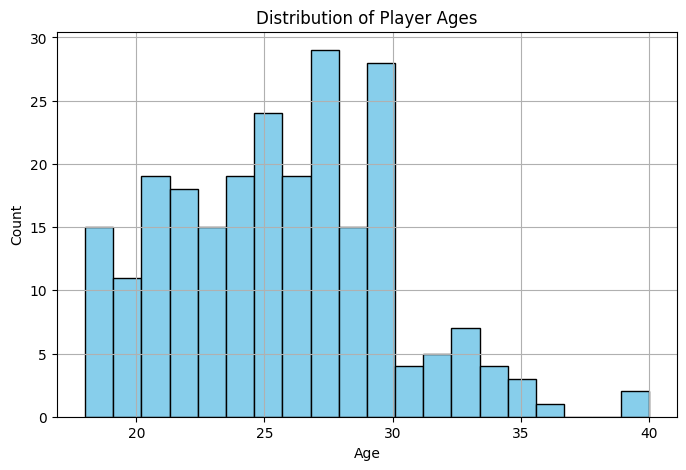

In [12]:
# 1. Quick summary of the dataset
utils.quick_summary(df)

# 2. Check missing values per column
print('Missing values per column:')
print(df.isnull().sum())

# 3. Convert relevant columns to numeric (adjust column names as needed)
numeric_cols = ['Age', 'Goals', 'Assists', 'Pass Completion %']
df = utils.to_numeric_safe(df, numeric_cols)

# 4. Visualize age distribution
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))
df['Age'].hist(bins=20, ax=ax, color='skyblue', edgecolor='black')
ax.set_title('Distribution of Player Ages')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
plt.show()


## Section 1.1: What trends exist in the data with regards to player age and performance metrics?

Correlation of Age with metrics (RBs):


,corr_with_age
Successful Tackles per90,-0.302612
Interceptions per90,-0.207776
Goals per90,-0.180974
Progressive Carries per90,-0.168743
Ball Prog. by Carrying per90,-0.161611
Assists per90,-0.091397
Open Play Key Passes per90,-0.084462
% Passing,-0.028769
Expected Assists per90,-0.020872
Completed Crosses per90,0.136254


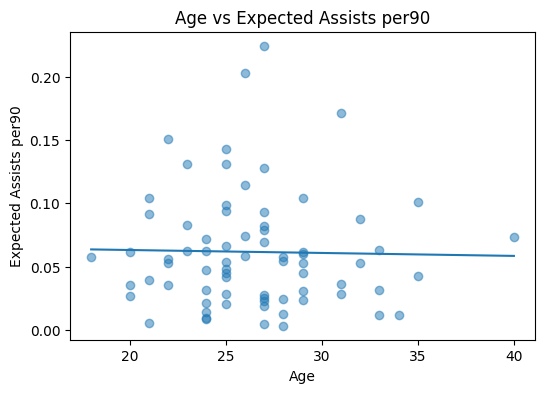

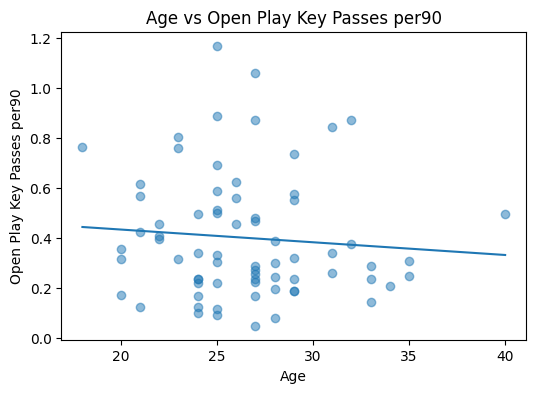

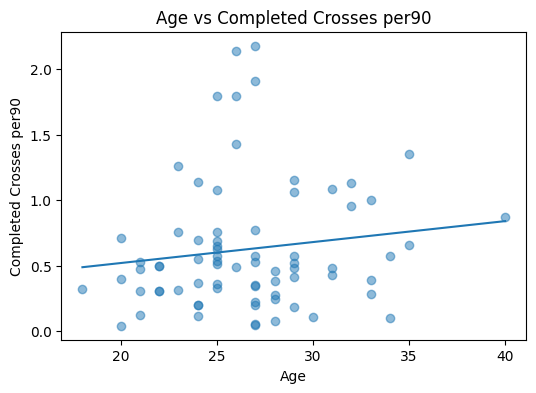

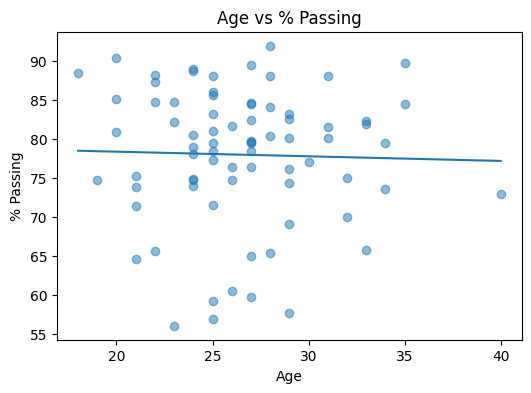

/var/folders/hw/gxw8_75x65q5_hhdgyw_24j40000gn/T/ipykernel_45764/3252954014.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_summary = rb.groupby("Age Band")[band_metrics].median().reindex(labels)


,Expected Assists per90,Open Play Key Passes per90,Completed Crosses per90,Progressive Carries per90,Successful Tackles per90,Interceptions per90,% Passing
Age Band,,,,,,,
≤21,0.048393,0.388622,0.363241,1.266120,2.817116,1.162603,75.3
22–24,0.052403,0.329616,0.433023,1.330869,3.060633,1.152181,80.5
25–27,0.067978,0.457627,0.574805,1.450739,2.702475,1.096458,79.5
28–30,0.048632,0.271424,0.417957,1.207430,2.323722,1.047791,80.2
31+,0.047727,0.296782,0.655738,1.106234,2.262295,0.968023,80.2


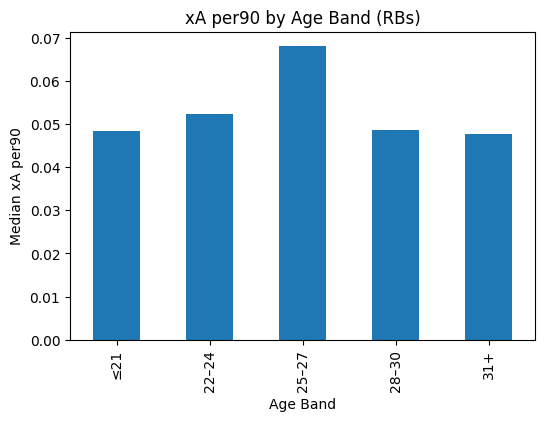

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Filter to right-backs and apply minutes floor
rb = df[df["Position"].astype(str).isin(["DR","DMR"])]
rb = rb[rb["Minutes"].fillna(0) >= 720].copy()  # ~8 full games

# 2. Select and coerce relevant columns to numeric
num_cols = [
    "Age","Minutes","Goals","Assists","% Passing","Expected Assists",
    "Open Play Key Passes","Completed Crosses","Progressive Carries",
    "Ball Prog. by Carrying","Successful Tackles","Interceptions",
    "Expected Threat (xT)","xT Passing"
 ]
have = [c for c in num_cols if c in rb.columns]
rb = utils.to_numeric_safe(rb, have)

# 3. Create per-90 metrics for counting stats
per90_candidates = [
    "Goals","Assists","Open Play Key Passes","Completed Crosses",
    "Progressive Carries","Ball Prog. by Carrying","Successful Tackles","Interceptions",
    "Expected Assists","Expected Threat (xT)","xT Passing"
 ]
per90 = [c for c in per90_candidates if c in rb.columns]
for c in per90:
    rb[c + " per90"] = rb[c] / (rb["Minutes"] / 90.0)

# 4. Correlation: Age vs key per-90/percentage metrics
age_vs = [c for c in rb.columns if c.endswith("per90")] + ["% Passing"]
age_vs = [c for c in age_vs if c in rb.columns]
age_corr = rb[["Age"] + age_vs].corr(numeric_only=True)["Age"].drop("Age").sort_values()
print("Correlation of Age with metrics (RBs):")
display(age_corr.to_frame("corr_with_age"))

# 5. Scatter plots with trendlines for headline metrics
def scatter_with_trend(df, x, y, title):
    d = df[[x,y]].dropna()
    plt.figure(figsize=(6,4))
    plt.scatter(d[x], d[y], alpha=0.5)
    if len(d) > 2:
        m, b = np.polyfit(d[x], d[y], 1)
        xs = np.linspace(d[x].min(), d[x].max(), 100)
        plt.plot(xs, m*xs + b)
    plt.title(title); plt.xlabel(x); plt.ylabel(y)
    plt.show()

for metric in [m for m in ["Expected Assists per90","Open Play Key Passes per90","Completed Crosses per90","% Passing"] if m in rb.columns]:
    scatter_with_trend(rb, "Age", metric, f"Age vs {metric}")

# 6. Age bands and summary
bins = [0,21,24,27,30,99]
labels = ["≤21","22–24","25–27","28–30","31+"]
rb["Age Band"] = pd.cut(rb["Age"], bins=bins, labels=labels, right=True)

band_metrics = [m for m in ["Expected Assists per90","Open Play Key Passes per90","Completed Crosses per90",
                            "Progressive Carries per90","Successful Tackles per90","Interceptions per90","% Passing"]
                if m in rb.columns]

band_summary = rb.groupby("Age Band")[band_metrics].median().reindex(labels)
display(band_summary)

# Quick bar example
ax = band_summary["Expected Assists per90"].plot(kind="bar", figsize=(6,4), title="xA per90 by Age Band (RBs)")
ax.set_ylabel("Median xA per90")
plt.show()

## Section 1.2: What drives market value for right-backs?


Correlation with (€) Market Value:
Goals per90                    -0.155381
Interceptions per90            -0.021667
Successful Tackles per90        0.002809
Completed Crosses per90         0.006354
Assists per90                   0.024299
Open Play Key Passes per90      0.069851
Expected Assists per90          0.288720
Progressive Carries per90       0.295776
Ball Prog. by Carrying per90    0.376558
% Passing                       0.419226
Minutes                         0.610720


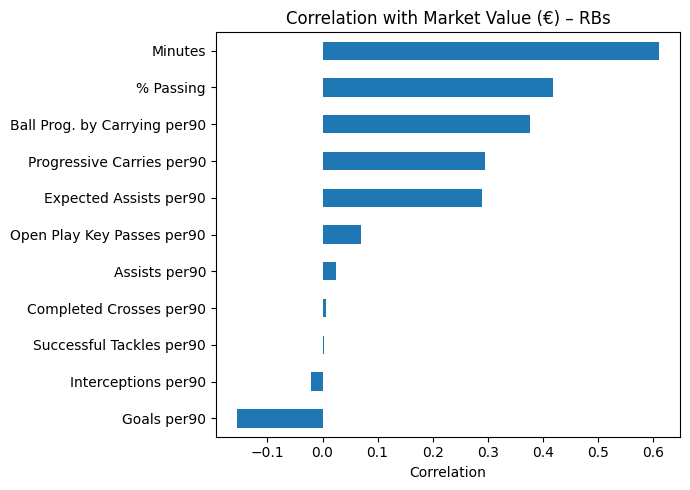

In [14]:
# 1. Filter RBs and coerce relevant columns to numeric
value_col = "(€) Market Value"
base_cols = ["Minutes","% Passing","Goals","Assists","Expected Assists",
             "Open Play Key Passes","Completed Crosses",
             "Progressive Carries","Ball Prog. by Carrying",
             "Successful Tackles","Interceptions"]
rb = df[df["Position"].astype(str).isin(["DR","DMR"])]
rb = rb[rb["Minutes"].fillna(0) >= 720].copy()
have = [c for c in [value_col] + base_cols if c in rb.columns]
rb = utils.to_numeric_safe(rb, have)
rb = rb.dropna(subset=[value_col])

# 2. Create per-90 metrics for counting stats
per90_candidates = ["Goals","Assists","Expected Assists","Open Play Key Passes",
                    "Completed Crosses","Progressive Carries","Ball Prog. by Carrying",
                    "Successful Tackles","Interceptions"]
for c in [x for x in per90_candidates if x in rb.columns]:
    rb[c + " per90"] = rb[c] / (rb["Minutes"] / 90.0)

# 3. Correlations with market value
test_cols = ["Minutes","% Passing"] + [c+" per90" for c in per90_candidates if (c+" per90") in rb.columns]
use = [c for c in test_cols if c in rb.columns] + [value_col]
corr = utils.show_correlations(rb, use, value_col)

# quick bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
corr.plot(kind="barh")
plt.title("Correlation with Market Value (€) – RBs")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()

## Section 1.3: Which metrics correlate to high performance among right-backs?

PerformanceIndex_B includes: ['Expected Assists', 'Open Play Key Passes', 'Progressive Carries', 'Ball Prog. by Carrying', 'Successful Tackles', 'Interceptions']


,corr_with_performance
Ball Prog. by Carrying per90,0.871751
Progressive Carries per90,0.819917
Successful Tackles per90,0.747907
Open Play Key Passes per90,0.722767
Expected Assists per90,0.702946
Interceptions per90,0.667262
% Passing,0.271961
Assists per90,-0.109204
Goals per90,-0.144595


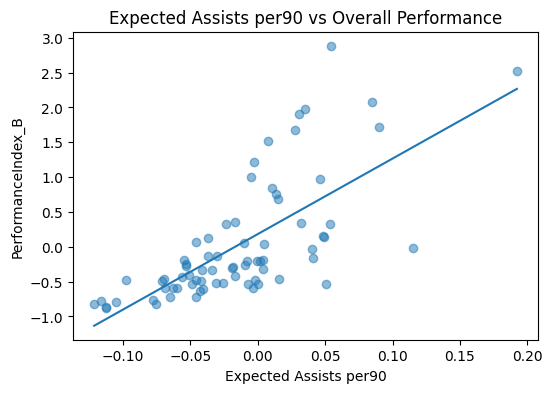

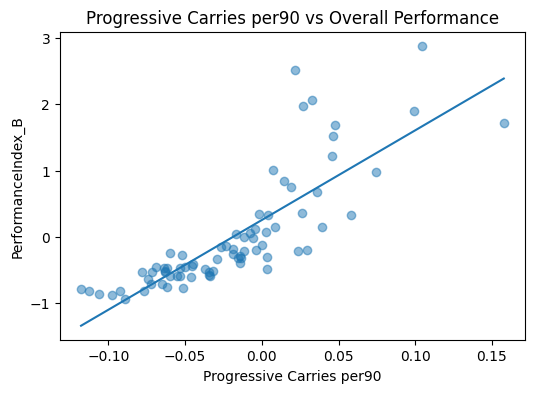

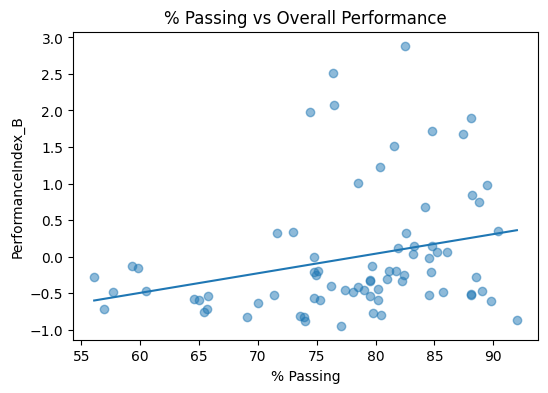

In [ ]:
# 1. Filter and clean (same as before)
rb = df[df["Position"].astype(str).isin(["DR","DMR"])]
rb = rb[rb["Minutes"].fillna(0) >= 720].copy()

# Ensure all relevant columns are numeric for all calculations
all_numeric_cols = [
    "Expected Assists", "Open Play Key Passes", "Progressive Carries",
    "Ball Prog. by Carrying", "Successful Tackles", "Interceptions",
    "Minutes", "% Passing"
 ]
for col in all_numeric_cols:
    if col in rb.columns:
        rb[col] = pd.to_numeric(rb[col], errors='coerce')

# 2. Normalized (z-score) aggregate performance index 
from sklearn.preprocessing import StandardScaler
cols_perf = ["Expected Assists","Open Play Key Passes","Progressive Carries",
             "Ball Prog. by Carrying","Successful Tackles","Interceptions"]
cols_perf = [c for c in cols_perf if c in rb.columns]
rb_scaled = rb.copy()
if cols_perf:
    rb_scaled[cols_perf] = StandardScaler().fit_transform(rb_scaled[cols_perf])
    rb_scaled["PerformanceIndex_B"] = rb_scaled[cols_perf].mean(axis=1)
    print(f"PerformanceIndex_B includes: {cols_perf}")
else:
    rb_scaled["PerformanceIndex_B"] = np.nan

# 3. Create per-90 metrics for counting stats
counting = ["Expected Assists","Open Play Key Passes",
            "Progressive Carries","Ball Prog. by Carrying",
            "Successful Tackles","Interceptions"]
for c in [x for x in counting if x in rb.columns]:
    rb[c + " per90"] = rb[c] / (rb["Minutes"] / 90.0)
    rb_scaled[c + " per90"] = rb_scaled[c] / (rb_scaled["Minutes"] / 90.0) if c in rb_scaled.columns else np.nan

# 4. Correlate metrics with the performance index
perf_cols = [c for c in rb_scaled.columns if c.endswith("per90")] + ["% Passing"]
perf_cols = [c for c in perf_cols if c in rb_scaled.columns]
if "PerformanceIndex_B" in rb_scaled.columns:
    corr_perf = rb_scaled[perf_cols + ["PerformanceIndex_B"]].corr(numeric_only=True)["PerformanceIndex_B"]
    corr_perf = corr_perf.drop("PerformanceIndex_B").sort_values(ascending=False)
    display(corr_perf.to_frame("corr_with_performance"))

    # Optional: horizontal bar chart
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,5))
    corr_perf.plot(kind="barh")
    plt.title("Correlation with Performance Index (RBs)")
    plt.xlabel("Correlation")
    plt.tight_layout()
    plt.show()

# 5. Visual checks: scatter plots for key metrics
def scatter_with_trend(df, x, y, title):
    d = df[[x,y]].dropna()
    plt.figure(figsize=(6,4))
    plt.scatter(d[x], d[y], alpha=0.5)
    if len(d) > 2:
        m, b = np.polyfit(d[x], d[y], 1)
        xs = np.linspace(d[x].min(), d[x].max(), 100)
        plt.plot(xs, m*xs + b)
    plt.title(title); plt.xlabel(x); plt.ylabel(y)
    plt.show()

for metric in [m for m in ["Expected Assists per90","Progressive Carries per90","% Passing"] if m in rb_scaled.columns]:
    scatter_with_trend(rb_scaled, metric, "PerformanceIndex_B", f"{metric} vs Overall Performance")